# ЛР 4. Наивный байесовский классификатор

## Подготовка

Импортируем нужные нам модули

In [1]:
from os import walk
import re

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_curve, precision_score, accuracy_score, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

Пройдёмся по всем файлам и импортируем из них данные (формат очень удобный, да)

In [2]:
_, _, files = walk("./messages/").__next__()

X = []
Y = []
for file in files:
    with open("./messages/" + file, "r") as f:
        header = f.readline()
        no = f.readline()
        message = f.readline()
        pred = re.search("^.*legit.*$", file)
        if (pred):
            Y.append(0)
        else:
            Y.append(1)
        tmp_arr = np.array(" ".join(header.split()[1:]) + " " + message).astype(str)
        X.append(tmp_arr)
        
X = np.array(X)
Y = np.array(Y)

Преобразуем данные в разреженный набор признаков

In [3]:
c_vec = CountVectorizer()
c_vec.fit(X)
doc_array = c_vec.transform(X).toarray()
doc_array.shape
X_vec = c_vec.fit_transform(X).toarray()

Разделим данные на тренировочную и тестовую выборки

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X_vec, Y, train_size=0.9)

Выведем итоговую матрицу с векторизованными данными

In [5]:
freq_matrix = pd.DataFrame(doc_array, columns=c_vec.get_feature_names())
freq_matrix

,10,100,1000,10000,10001,10002,10003,10004,10005,10006,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1. Кросс-валидация

Проведём кросс-валидацию данных с использованием наивного байесовского классификатора и посмотрим различные метрики

R^2:       64.63%
Recall:    81.88%
Precision: 98.17%
F1:        88.89%
Accuracy:  91.28%
AUC ROC:   99.12%


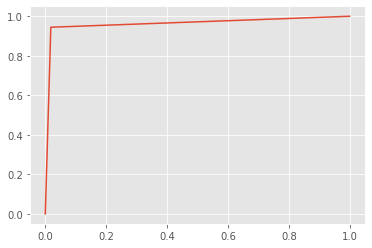

In [6]:
scores = cross_validate(BernoulliNB(), X_vec, Y, cv=10, 
                        scoring=('r2', 'recall', 'precision', 'f1', 'accuracy', 'roc_auc'),
                        return_train_score=True)

fpr, tpr, thresholds = roc_curve(Y_test, BernoulliNB().fit(X_train, Y_train).predict(X_test))
plt.plot(fpr, tpr)
print(f"R^2:       {(sum(scores['test_r2']) / 10):.2%}")
print(f"Recall:    {(sum(scores['test_recall']) / 10):.2%}")
print(f"Precision: {(sum(scores['test_precision']) / 10):.2%}")
print(f"F1:        {(sum(scores['test_f1']) / 10):.2%}")
print(f"Accuracy:  {(sum(scores['test_accuracy']) / 10):.2%}")
print(f"AUC ROC:   {(sum(scores['test_roc_auc']) / 10):.2%}")

## 2. Поиск оптимальных параметров

Подготовим пары весов для самописного grid search. Здесь вес спама не меняется, меняется только вес нормальных писем:

In [7]:
tmp_alpha1 = np.arange(1e-11, 1e10, 5e8).reshape(-1, 1)
tmp_alpha2 = np.array([1e-11] * len(tmp_alpha1)).reshape(-1, 1)

fog_gc = np.append(tmp_alpha1, tmp_alpha2, axis=1).tolist()

Подберём оптимальные параметры для максимизации точности (precision). Точность мы максимизируем в соответствии с заданием (ни одно нормальное письмо не должно улететь в спам):

In [8]:
best_score_pre = 0
best_grid_pre = []

for i in fog_gc:
    clf = BernoulliNB(class_prior=i)
    clf = clf.fit(X_vec, Y)
    Y_pred = clf.predict(X_vec)
    pre = precision_score(Y, Y_pred)
    if pre > best_score_pre:
        best_score_pre = pre
        best_grid_pre = i

print(f"Best parameters for precision: {best_grid_pre}")
print(f"Best score:                    {best_score_pre:.2%}")

Best parameters for precision: [4000000000.0, 1e-11]
Best score:                    100.00%


Построим идеальный с точки зрения точности классификатор и его матрицу ошибок:

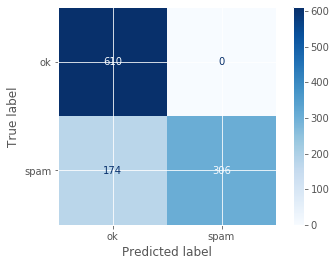

In [9]:
clf1 = BernoulliNB(class_prior=best_grid_pre)
clf1 = clf1.fit(X_vec, Y)

plot_confusion_matrix(clf1, X_vec, Y, cmap=plt.cm.Blues, display_labels=["ok", "spam"], values_format='d')

Посмотрим, как меняется точность в зависимости от веса нормальных писем:

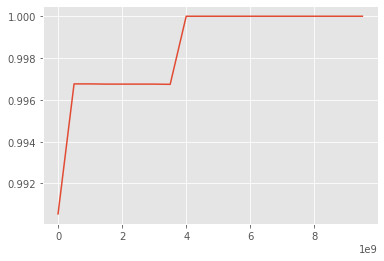

In [10]:
scores = []
alpha = []
for i in fog_gc:
    clf = BernoulliNB(class_prior=i)
    clf = clf.fit(X_vec, Y)
    scores.append(precision_score(Y, clf.predict(X_vec)))
    alpha.append(i[0])

plt.plot(alpha, scores)


## 3. Поиск оптимальных параметров для другой метрики

Ради интереса посмотрим, как хорошо будет работать классификатор, если максимизировать не precision, а accuracy.

Сгенерируем пары весов для самописного grid search и найдём наилучшую пару:

In [11]:
tmp_alpha1 = np.arange(1, 1e5, 1e4).reshape(-1, 1)
tmp_alpha2 = np.array([1e5] * len(tmp_alpha1)).reshape(-1, 1)

fog_gc = np.append(tmp_alpha1, tmp_alpha2, axis=1).tolist()

best_score = 0
for i in fog_gc:
    clf = BernoulliNB(class_prior=i)
    clf = clf.fit(X_vec, Y)
    Y_pred = clf.predict(X_vec)
    acc = accuracy_score(Y, Y_pred)
    if (acc > best_score):
        best_score = acc
        best_grid = i

print(f"Best parameters for accuracy: {best_grid}")
print(f"Best score: {best_score:.2%}")

Best parameters for accuracy: [1.0, 100000.0]
Best score: 96.70%


Посмотрим, насколько точно классификатор с такими параметрами распределяет письма:

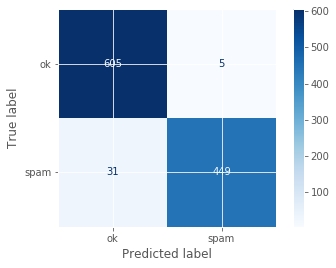

In [12]:
clf1 = BernoulliNB(class_prior=best_grid)
clf1 = clf1.fit(X_vec, Y)

plot_confusion_matrix(clf1, X_vec, Y,
                      cmap=plt.cm.Blues,
                      display_labels=["ok", "spam"],
                      values_format='d')